In [94]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import imageio
import scipy
from sklearn import preprocessing
from scipy import signal
import timit_utils as tu
import timit_utils.audio_utils as au
import timit_utils.drawing_utils as du
import librosa
import pywt
import random
from skimage.measure import block_reduce

corpus = tu.Corpus('TIMIT')
train = corpus.train
test = corpus.test
corpus.train, corpus.test

(<timit_utils.core.SubCorpus at 0x1767de41c48>,
 <timit_utils.core.SubCorpus at 0x176803d6d48>)

### Check for length of sentences.

Max sentence length in training set is  7.7888125  seconds.
Min sentence length in training set is  0.91525  seconds.


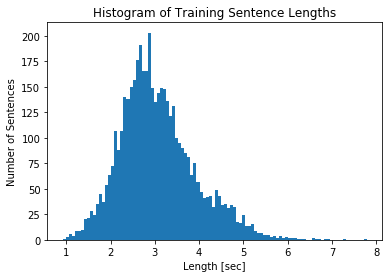

In [2]:
sentence_lengths = []
for p in range(len(train.people)):
    for s in range(len(train.person_by_index(p).sentences)):
        sentence = train.person_by_index(p).sentence_by_index(s).raw_audio
        sentence_lengths.append(len(sentence))
print('Max sentence length in training set is ', max(sentence_lengths)/16000, ' seconds.')
print('Min sentence length in training set is ', min(sentence_lengths)/16000, ' seconds.')
plt.hist([x / 16000 for x in sentence_lengths], bins=100)
plt.title('Histogram of Training Sentence Lengths')
plt.xlabel('Length [sec]')
plt.ylabel('Number of Sentences')
plt.show()

Max sentence length in testing set is  7.57125  seconds.
Min sentence length in testing set is  1.0944375  seconds.


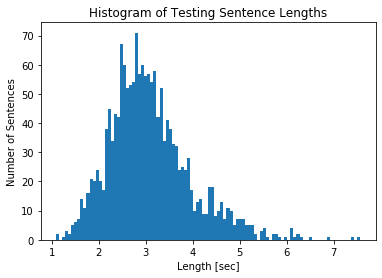

In [3]:
sentence_lengths = []
for p in range(len(test.people)):
    for s in range(len(test.person_by_index(p).sentences)):
        sentence = test.person_by_index(p).sentence_by_index(s).raw_audio
        sentence_lengths.append(len(sentence))
print('Max sentence length in testing set is ', max(sentence_lengths)/16000, ' seconds.')
print('Min sentence length in testing set is ', min(sentence_lengths)/16000, ' seconds.')
plt.hist([x / 16000 for x in sentence_lengths], bins=100)
plt.title('Histogram of Testing Sentence Lengths')
plt.xlabel('Length [sec]')
plt.ylabel('Number of Sentences')
plt.show()

### Split sentences into training and testing data

In [4]:
data_set = []
label_id = []
label_gen = []
label_dem = []
for p in range(len(train.people)):
    count = 0
    for s in range(len(train.person_by_index(p).sentences)):
        sentence = train.person_by_index(p).sentence_by_index(s).raw_audio
        data_set.append(sentence)
        label_id.append(train.person_by_index(p).name)
        label_gen.append(train.person_by_index(p).gender)
        label_dem.append(train.person_by_index(p).region_name)
for p in range(len(test.people)):
    count = 0
    for s in range(len(test.person_by_index(p).sentences)):
        sentence = test.person_by_index(p).sentence_by_index(s).raw_audio
        data_set.append(sentence)
        label_id.append(test.person_by_index(p).name)
        label_gen.append(test.person_by_index(p).gender)
        label_dem.append(test.person_by_index(p).region_name)
num_speakers = len(set(label_id))
print('Number of speakers in data: ', num_speakers)

Number of speakers in data:  630


In [5]:
le1 = preprocessing.LabelEncoder()
le1.fit(label_id)
label_id = le1.transform(label_id)
le2 = preprocessing.LabelEncoder()
le2.fit(label_gen)
label_gen = le2.transform(label_gen)
le3 = preprocessing.LabelEncoder()
le3.fit(label_dem)
label_dem = le3.transform(label_dem)

N = 20 # number of speakers being considered
sub_data_set = []
sub_label_id = []
sub_label_gen = []
sub_label_dem = []
speak_ind = []
for ind1 in range(N):
    ind2 = np.random.randint(630, size=1)
    while ind2[0] in speak_ind is False:
        ind2 = np.random.randint(630, size=1)
    speak_ind.append(ind2[0])
act_ind = []
for ID in speak_ind:
    act_ind= np.where(label_id == ID)
    sub_data_set = sub_data_set+data_set[act_ind[0][0]:act_ind[0][-1]+1]
    sub_label_id = sub_label_id+label_id[act_ind[0]].tolist()
    sub_label_gen = sub_label_gen+label_gen[act_ind[0]].tolist()
    sub_label_dem = sub_label_dem+label_dem[act_ind[0]].tolist()

In [6]:
num_train_per_test = 3 # for every 3 training sentences, there is 1 testing sentence
training_set = []
training_label_id = []
training_label_gen = []
training_label_dem = []
testing_set = []
testing_label_id = []
testing_label_gen = []
testing_label_dem = []
for ID in speak_ind:
    person_ind = [i for i, x in enumerate(sub_label_id) if x == ID]
    testing_subset = []
    training_subset = []
    for i, sent_per_ID in enumerate(person_ind):
        if i%(num_train_per_test+1) == 0:
            testing_subset=testing_subset+sub_data_set[sent_per_ID].tolist()
        else:
            training_subset=training_subset+sub_data_set[sent_per_ID].tolist()
    testing_set.append(testing_subset)
    training_set.append(training_subset)
    testing_label_id.append(ID)
    testing_label_gen.append(sub_label_gen[sent_per_ID])
    testing_label_dem.append(sub_label_dem[sent_per_ID])
    training_label_id.append(ID)
    training_label_gen.append(sub_label_gen[sent_per_ID])
    training_label_dem.append(sub_label_dem[sent_per_ID])

In [152]:
len_samps = 1 # length of samples in seconds
fs = 16000
ave_seconds_per_ID = sum(sentence_lengths)/(fs*len(sentence_lengths))*10
num_samps_per_ID = round(ave_seconds_per_ID)*10
num_samps_per_ID_test = round(num_samps_per_ID*(1/(num_train_per_test+1)))
num_samps_per_ID_train = num_samps_per_ID-num_samps_per_ID_test
training_data = []
training_l_id = []
training_l_gen = []
training_l_dem = []
testing_data = []
testing_l_id = []
testing_l_gen = []
testing_l_dem = []
for ID_i, ID in enumerate(speak_ind):
    train_speech_loop = training_set[ID_i]+training_set[ID_i][0:round(fs*len_samps)]
    test_speech_loop = testing_set[ID_i]+testing_set[ID_i][0:round(fs*len_samps)]
    for samp in range(num_samps_per_ID_train):
        start_i = random.randint(0,len(training_set[ID_i])-round(fs*len_samps))
        training_data.append(np.asarray(train_speech_loop[start_i:start_i+round(fs*len_samps)]))
        training_l_id.append(ID_i)
        training_l_gen.append(training_label_gen[ID_i])
        training_l_dem.append(training_label_dem[ID_i])
    for samp in range(num_samps_per_ID_test):
        start_i = random.randint(0,len(testing_set[ID_i])-round(fs*len_samps))
        testing_data.append(np.asarray(test_speech_loop[start_i:start_i+round(fs*len_samps)]))
        testing_l_id.append(ID_i)
        testing_l_gen.append(testing_label_gen[ID_i])
        testing_l_dem.append(testing_label_dem[ID_i])

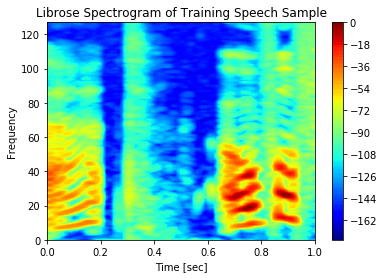

Size of spectrogram is:  (128, 101)


In [153]:
# Visualization of spectrogram from Librosa
plt.title('Librose Spectrogram of Training Speech Sample')
plt.xlabel('Time [sec]')
plt.ylabel('Frequency')
S = librosa.feature.melspectrogram(y=training_data[0], sr=16000, n_fft=1024, hop_length=160)
S = S/np.amax(S)
t = np.arange(0,1.01,0.01)
f = np.arange(0,128,1)
plt.contourf(t,f,20*np.log10(S),100,cmap='jet')
plt.colorbar()
plt.show()
print('Size of spectrogram is: ', np.shape(S))

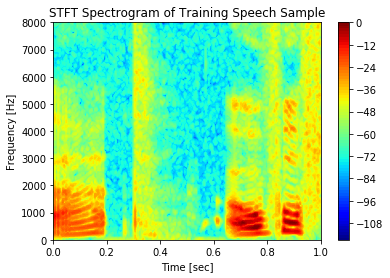

Size of spectrogram is:  (129, 168)


In [154]:
# Visualization of typical STFT spectrogram
plt.title('STFT Spectrogram of Training Speech Sample')
plt.xlabel('Time [sec]')
plt.ylabel('Frequency [Hz]')
f, t, spectrogram = scipy.signal.stft(training_data[0], nfft=256, fs=16000, detrend=False, noverlap=160)
spectrogram = abs(spectrogram)/np.amax(abs(spectrogram))
plt.contourf(t,f,20*np.log10(spectrogram),100,cmap='jet')
plt.colorbar()
plt.show()
print('Size of spectrogram is: ', np.shape(spectrogram))

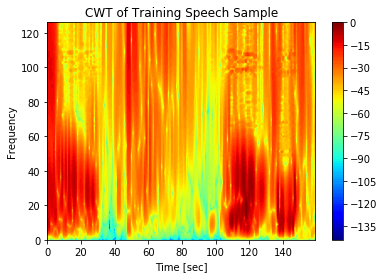

Size of spectrogram is:  (127, 160)


In [155]:
# Visualization of  continuous wavelet transform
plt.title('CWT of Training Speech Sample')
plt.xlabel('Time [sec]')
plt.ylabel('Frequency')
cwt, f = pywt.cwt(training_data[0], np.arange(1, 128), "gaus4")
cwt = block_reduce(cwt, block_size=(1,100), func=np.mean)
cwt = abs(cwt)/np.max(abs(cwt))
plt.contourf(20*np.log10(cwt),100,cmap='jet')
plt.colorbar()
plt.show()
print('Size of spectrogram is: ', np.shape(cwt))

### For Groupmates: Data loaders for time-series input.

In [105]:
batch_size = 30
train_loader,test_loader = {},{}
train_list = []
for ind, data in enumerate(training_data):
    train_list.append((data, training_l_id[ind], training_l_gen[ind], training_l_dem[ind]))
test_list = []
for ind, data in enumerate(testing_data):
    test_list.append((data, testing_l_id[ind], testing_l_gen[ind], testing_l_dem[ind]))
train_loader['timit'] = torch.utils.data.DataLoader(train_list, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader['timit'] = torch.utils.data.DataLoader(test_list, batch_size=batch_size, shuffle=True, num_workers=0)

### Functions for Network

In [157]:
def train(model, device, train_loader, criterion, optimizer, epoch):
    train_loss = 0
    model.train()
    model.double()
    for batch_idx, (data, target1, target2, target3) in enumerate(train_loader):
        data, target1, target2, target3=data.to(device), target1.to(device), target2.to(device), target3.to(device)
        data = data.reshape(len(data),1,data[0].size()[0],data[0].size()[1])
        optimizer.zero_grad()
        output1, output2, output3 = model(data)
        loss = (0.9*criterion(output1, target1))+(0.05*criterion(output2, target2))+(0.05*criterion(output3, target3)) 
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

def test(model, device, test_loader, criterion, epoch):
    model.eval()
    model.double()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target1, target2, target3 in test_loader:
            data, target1, target2, target3=data.to(device), target1.to(device), target2.to(device), target3.to(device)
            data = data.reshape(len(data),1,data[0].size()[0],data[0].size()[1])
            output1, output2, output3 = model(data)
            test_loss += criterion(output1, target1).item() # sum up batch loss
            pred = output1.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target1.view_as(pred)).sum().item()

    test_loss = (test_loss*batch_size)/len(test_loader.dataset)
    print('Test({}): Loss: {:.4f}, Accuracy: {:.4f}%'.format(
        epoch, test_loss, 100. * correct / len(test_loader.dataset)))

In [158]:
def make_optimizer(optimizer_name, model, **kwargs):
    if optimizer_name=='Adam':
        optimizer = optim.Adam(model.parameters(),lr=kwargs['lr'])
    elif optimizer_name=='SGD':
        optimizer = optim.SGD(model.parameters(),lr=kwargs['lr'],momentum=kwargs['momentum'], weight_decay=kwargs['weight_decay'],nesterov=True)
    else:
        raise ValueError('Not valid optimizer name')
    return optimizer
    
def make_scheduler(scheduler_name, optimizer, **kwargs):
    if scheduler_name=='MultiStepLR':
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer,milestones=kwargs['milestones'],gamma=kwargs['factor'])
    else:
        raise ValueError('Not valid scheduler name')
    return scheduler

# Librosa Spectrogram Inputs

### Data saved as spectrogram images

In [159]:
# Using Librosa spectrograms.
batch_size = 30
train_loader,test_loader = {},{}
train_list = []
for ind, data in enumerate(training_data):
    spectrogram = librosa.feature.melspectrogram(y=training_data[ind], sr=16000, n_fft=1024, hop_length=160)
    spectrogram = spectrogram/np.amax(spectrogram)
    train_list.append((20*np.log10(abs(spectrogram)), training_l_id[ind], training_l_gen[ind], training_l_dem[ind]))
test_list = []
for ind, data in enumerate(testing_data):
    spectrogram = librosa.feature.melspectrogram(y=testing_data[ind], sr=16000, n_fft=1024, hop_length=160)
    spectrogram = spectrogram/np.amax(spectrogram)
    test_list.append((20*np.log10(abs(spectrogram)), testing_l_id[ind], testing_l_gen[ind], testing_l_dem[ind]))
train_loader['timit'] = torch.utils.data.DataLoader(train_list, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader['timit'] = torch.utils.data.DataLoader(test_list, batch_size=batch_size, shuffle=True, num_workers=0)
print('Done with calculating spectrograms.')

Done with calculating spectrograms.


### Construct the CNN architecture.

In [160]:
class LeNet5(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=30, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(in_channels=30, out_channels=15, kernel_size=3, stride=1)
        self.fc1   = nn.Linear(in_features=15*30*23, out_features=200)
        self.drop1 = nn.Dropout(p=0.5, inplace=False)
        self.fc3_1   = nn.Linear(in_features=200, out_features=out_channels)
        self.fc3_2   = nn.Linear(in_features=200, out_features=out_channels)
        self.fc3_3   = nn.Linear(in_features=200, out_features=out_channels)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x),0)
        x = F.max_pool2d(x, 2)
        x = F.leaky_relu(self.conv2(x),0)
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1) # flattens
        x = F.leaky_relu(self.fc1(x),0)
        x = self.drop1(x)
        x1 = F.softmax(self.fc3_1(x),dim=0)
        x2 = F.softmax(self.fc3_2(x),dim=0)
        x3 = F.softmax(self.fc3_3(x),dim=0)
        return x1, x2, x3

In [161]:
seed = 1
device = 'cpu'
data_name = 'timit'
optimizer_name = 'SGD'
scheduler_name = 'MultiStepLR'
num_epochs = 10
lr = 0.005
device = torch.device(device)
torch.manual_seed(1)
in_channels = 1
out_channels = N
model = LeNet5(in_channels, out_channels).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = make_optimizer(optimizer_name, model, lr=lr, momentum=0.5, weight_decay=0)
scheduler = make_scheduler(scheduler_name, optimizer, milestones=[5,10,15], factor=0.1)
for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader[data_name], criterion, optimizer, epoch)
    test(model, device, test_loader[data_name], criterion, epoch)
    scheduler.step()

Test(1): Loss: 2.9895, Accuracy: 11.4103%
Test(2): Loss: 2.9704, Accuracy: 22.1795%
Test(3): Loss: 2.8661, Accuracy: 43.2692%
Test(4): Loss: 2.7587, Accuracy: 51.0897%
Test(5): Loss: 2.6742, Accuracy: 57.2436%
Test(6): Loss: 2.6636, Accuracy: 57.3077%
Test(7): Loss: 2.6539, Accuracy: 57.8846%
Test(8): Loss: 2.6562, Accuracy: 58.2692%
Test(9): Loss: 2.6510, Accuracy: 58.4615%
Test(10): Loss: 2.6307, Accuracy: 60.8333%


# STFT Spectrogram Inputs

### Data saved as spectrogram images

In [162]:
# Using STFT spectrograms.
batch_size = 30
train_loader,test_loader = {},{}
train_list = []
for ind, data in enumerate(training_data):
    f, t, spectrogram = scipy.signal.stft(training_data[ind], nfft=256, fs=16000, detrend=False, noverlap=160)
    spectrogram = abs(spectrogram)/np.amax(abs(spectrogram))
    train_list.append((20*np.log10(abs(spectrogram)), training_l_id[ind], training_l_gen[ind], training_l_dem[ind]))
test_list = []
for ind, data in enumerate(testing_data):
    f, t, spectrogram = scipy.signal.stft(testing_data[ind], nfft=256, fs=16000, detrend=False, noverlap=160)
    spectrogram = abs(spectrogram)/np.amax(abs(spectrogram))
    test_list.append((20*np.log10(abs(spectrogram)), testing_l_id[ind], testing_l_gen[ind], testing_l_dem[ind]))
train_loader['timit'] = torch.utils.data.DataLoader(train_list, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader['timit'] = torch.utils.data.DataLoader(test_list, batch_size=batch_size, shuffle=True, num_workers=0)
print('Done with calculating spectrograms.')

Done with calculating spectrograms.


### Construct the CNN architecture.

In [163]:
class LeNet5(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=30, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(in_channels=30, out_channels=15, kernel_size=3, stride=1)
        self.fc1   = nn.Linear(in_features=15*30*40, out_features=200)
        self.drop1 = nn.Dropout(p=0.5, inplace=False)
        self.fc3_1   = nn.Linear(in_features=200, out_features=out_channels)
        self.fc3_2   = nn.Linear(in_features=200, out_features=out_channels)
        self.fc3_3   = nn.Linear(in_features=200, out_features=out_channels)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x),0)
        x = F.max_pool2d(x, 2)
        x = F.leaky_relu(self.conv2(x),0)
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1) # flattens
        x = F.leaky_relu(self.fc1(x),0)
        x = self.drop1(x)
        x1 = F.softmax(self.fc3_1(x),dim=0)
        x2 = F.softmax(self.fc3_2(x),dim=0)
        x3 = F.softmax(self.fc3_3(x),dim=0)
        return x1, x2, x3

In [166]:
seed = 1
device = 'cpu'
data_name = 'timit'
optimizer_name = 'SGD'
scheduler_name = 'MultiStepLR'
num_epochs = 20
lr = 0.005
device = torch.device(device)
torch.manual_seed(1)
in_channels = 1
out_channels = N
model = LeNet5(in_channels, out_channels).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = make_optimizer(optimizer_name, model, lr=lr, momentum=0.5, weight_decay=0)
scheduler = make_scheduler(scheduler_name, optimizer, milestones=[5,10,15], factor=0.1)
for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader[data_name], criterion, optimizer, epoch)
    test(model, device, test_loader[data_name], criterion, epoch)
    scheduler.step()

Test(1): Loss: 2.9944, Accuracy: 6.9231%
Test(2): Loss: 2.9940, Accuracy: 9.9359%
Test(3): Loss: 2.9931, Accuracy: 13.9744%
Test(4): Loss: 2.9861, Accuracy: 26.6026%
Test(5): Loss: 2.9749, Accuracy: 38.2051%
Test(6): Loss: 2.9649, Accuracy: 41.3462%
Test(7): Loss: 2.9563, Accuracy: 43.3974%
Test(8): Loss: 2.9458, Accuracy: 45.5128%
Test(9): Loss: 2.9285, Accuracy: 46.2179%
Test(10): Loss: 2.9124, Accuracy: 46.3462%
Test(11): Loss: 2.9023, Accuracy: 45.8333%
Test(12): Loss: 2.9006, Accuracy: 46.6026%
Test(13): Loss: 2.8965, Accuracy: 46.4103%
Test(14): Loss: 2.8959, Accuracy: 46.6026%
Test(15): Loss: 2.8915, Accuracy: 45.8333%
Test(16): Loss: 2.8909, Accuracy: 46.2821%
Test(17): Loss: 2.8884, Accuracy: 48.0769%
Test(18): Loss: 2.8883, Accuracy: 47.4359%
Test(19): Loss: 2.8885, Accuracy: 46.7308%
Test(20): Loss: 2.8897, Accuracy: 48.2692%


# CWT Spectrogram Inputs

### Data saved as spectrogram images

In [167]:
# Using CWT spectrograms.
batch_size = 30
train_loader,test_loader = {},{}
train_list = []
for ind, data in enumerate(training_data):
    cwt, f = pywt.cwt(training_data[ind], np.arange(1, 128), "gaus4")
    cwt = block_reduce(cwt, block_size=(1,100), func=np.mean)
    spectrogram = abs(cwt)/np.max(abs(cwt))
    train_list.append((20*np.log10(abs(spectrogram)), training_l_id[ind], training_l_gen[ind], training_l_dem[ind]))
test_list = []
for ind, data in enumerate(testing_data):
    cwt, f = pywt.cwt(testing_data[ind], np.arange(1, 128), "gaus4")
    cwt = block_reduce(cwt, block_size=(1,100), func=np.mean)
    spectrogram = abs(cwt)/np.max(abs(cwt))
    test_list.append((20*np.log10(abs(spectrogram)), testing_l_id[ind], testing_l_gen[ind], testing_l_dem[ind]))
train_loader['timit'] = torch.utils.data.DataLoader(train_list, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader['timit'] = torch.utils.data.DataLoader(test_list, batch_size=batch_size, shuffle=True, num_workers=0)
print('Done with calculating spectrograms.')

Done with calculating spectrograms.


### Construct the CNN architecture.

In [174]:
class LeNet5(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=30, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(in_channels=30, out_channels=15, kernel_size=3, stride=1)
        self.fc1   = nn.Linear(in_features=15*30*38, out_features=200)
        self.drop1 = nn.Dropout(p=0.5, inplace=False)
        self.fc3_1   = nn.Linear(in_features=200, out_features=out_channels)
        self.fc3_2   = nn.Linear(in_features=200, out_features=out_channels)
        self.fc3_3   = nn.Linear(in_features=200, out_features=out_channels)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x),0)
        x = F.max_pool2d(x, 2)
        x = F.leaky_relu(self.conv2(x),0)
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1) # flattens
        x = F.leaky_relu(self.fc1(x),0)
        x = self.drop1(x)
        x1 = F.softmax(self.fc3_1(x),dim=0)
        x2 = F.softmax(self.fc3_2(x),dim=0)
        x3 = F.softmax(self.fc3_3(x),dim=0)
        return x1, x2, x3

In [175]:
seed = 1
device = 'cpu'
data_name = 'timit'
optimizer_name = 'SGD'
scheduler_name = 'MultiStepLR'
num_epochs = 20
lr = 0.005
device = torch.device(device)
torch.manual_seed(1)
in_channels = 1
out_channels = N
model = LeNet5(in_channels, out_channels).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = make_optimizer(optimizer_name, model, lr=lr, momentum=0.5, weight_decay=0)
scheduler = make_scheduler(scheduler_name, optimizer, milestones=[5,10,15], factor=0.1)
for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader[data_name], criterion, optimizer, epoch)
    test(model, device, test_loader[data_name], criterion, epoch)
    scheduler.step()

Test(1): Loss: 2.9793, Accuracy: 14.5513%
Test(2): Loss: 2.9620, Accuracy: 17.8205%
Test(3): Loss: 2.9556, Accuracy: 18.9103%
Test(4): Loss: 2.9395, Accuracy: 19.4231%
Test(5): Loss: 2.9405, Accuracy: 20.0000%
Test(6): Loss: 2.9339, Accuracy: 21.2821%
Test(7): Loss: 2.9294, Accuracy: 21.7949%
Test(8): Loss: 2.9272, Accuracy: 20.6410%
Test(9): Loss: 2.9279, Accuracy: 20.5769%
Test(10): Loss: 2.9242, Accuracy: 19.7436%
Test(11): Loss: 2.9250, Accuracy: 19.8077%
Test(12): Loss: 2.9225, Accuracy: 20.8974%
Test(13): Loss: 2.9222, Accuracy: 20.1923%
Test(14): Loss: 2.9208, Accuracy: 20.7051%
Test(15): Loss: 2.9182, Accuracy: 21.2179%
Test(16): Loss: 2.9186, Accuracy: 21.6026%
Test(17): Loss: 2.9189, Accuracy: 21.2179%
Test(18): Loss: 2.9218, Accuracy: 20.8333%
Test(19): Loss: 2.9179, Accuracy: 21.1538%
Test(20): Loss: 2.9210, Accuracy: 20.6410%
